In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
import math
import joblib
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/Multi_core/proprocessed_data_v1_s_p_speedup.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
y_col = ['Speedup']

In [4]:
X = data.drop(y_col, axis=1)
real_time = X['time']
real_time.rename('real-time', inplace=True)
y = data[y_col]

In [5]:
X.head()

,L1-icache-load-misses-percent,cache-misses-percent,dTLB-load-misses,iTLB-loads,cpu-used,user-time,task-clock,instructions_per_cycle,L1-icache-loads,iTLB-load-misses-percent,...,L1-dcache-load-misses,input-size,dTLB-load-misses-percent,dTLB-loads,L1-dcache-loads,LLC-load-misses-percent,Vanilla_time,s,p,Overhead
0,2.17,17.748,890791,1420493334,1.331,0.163,2.27465,0.62,1512684654,0.02,...,35340541,0,0.06,1474918765,1440859989,16.34,0.1700,0.02,0.15,2.775558e-17
1,3.50,15.963,691644,1207726784,1.195,0.143,1.90247,0.59,1129860292,0.02,...,35716092,0,0.05,1298296555,1204162498,20.51,0.0950,0.02,0.15,1.000000e-03
2,2.10,17.153,906193,1371134948,1.392,0.137,2.23073,0.58,1477703573,0.02,...,30699263,0,0.06,1440048177,1593171248,15.27,0.0700,0.02,0.15,2.000000e-03
3,2.50,16.563,817096,1276636211,1.282,0.135,2.01050,0.57,1301393436,0.03,...,33251076,0,0.06,1355002190,1295910258,17.52,0.0575,0.02,0.15,2.500000e-03
4,1.80,17.499,962960,1362047764,1.434,0.134,2.23717,0.61,1498956255,0.02,...,30187700,0,0.07,1404179600,1574108763,17.11,0.0500,0.02,0.15,3.000000e-03


In [6]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [7]:
X = pd.concat([real_time,X],axis=1)

In [8]:
X.head()

,real-time,L1-icache-load-misses-percent,cache-misses-percent,dTLB-load-misses,iTLB-loads,cpu-used,user-time,task-clock,instructions_per_cycle,L1-icache-loads,...,L1-dcache-load-misses,input-size,dTLB-load-misses-percent,dTLB-loads,L1-dcache-loads,LLC-load-misses-percent,Vanilla_time,s,p,Overhead
0,0.170,1.012506,1.060686,-0.215213,-0.711748,-0.711385,-0.807656,-0.773231,-0.706492,-0.695720,...,-0.539473,-1.224587,0.069403,-0.714549,-0.723085,0.629096,-0.540923,-0.499029,-0.777438,-0.389241
1,0.096,2.762486,0.679034,-0.253392,-0.754194,-0.808759,-0.810681,-0.824724,-0.820104,-0.771749,...,-0.537948,-1.224587,-0.021731,-0.737981,-0.754464,1.458683,-0.572140,-0.499029,-0.777438,-0.386057
2,0.072,0.920402,0.933469,-0.212260,-0.721595,-0.667710,-0.811588,-0.779308,-0.857975,-0.702667,...,-0.558319,-1.224587,0.069403,-0.719175,-0.702894,0.416229,-0.582546,-0.499029,-0.777438,-0.382874
3,0.060,1.446712,0.807321,-0.229341,-0.740447,-0.746469,-0.811891,-0.809778,-0.895845,-0.737683,...,-0.547958,-1.224587,0.069403,-0.730458,-0.742301,0.863848,-0.587748,-0.499029,-0.777438,-0.381283
4,0.053,0.525670,1.007448,-0.201378,-0.723408,-0.637639,-0.812042,-0.778417,-0.744363,-0.698447,...,-0.560396,-1.224587,0.160538,-0.723934,-0.705421,0.782281,-0.590870,-0.499029,-0.777438,-0.379691


In [9]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [10]:
#load Models
snet_path = "/content/drive/My Drive/Multi_core/SNet.pt"
pnet_path = "/content/drive/My Drive/Multi_core/PNet.pt"
oh_path = "/content/drive/My Drive/Multi_core/overhead_model.joblib"
SNet = torch.load(snet_path)
PNet = torch.load(pnet_path)
oh_predictor = joblib.load(oh_path)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
SNet.eval()

Sequential(
  (0): Linear(in_features=3, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)

In [12]:
PNet.eval()

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
)

In [13]:
def speedup_predictor(t_s, t_p, oh, t_run): 
  return (t_s + t_p + oh) / t_run

In [14]:
def modelSpeed(input):
  speedups = []
  input_s = torch.tensor(input[['time', 'cpu-cycles', 'dTLB-load-misses']].values)
  input_p = torch.tensor(input[['time', 'L1-dcache-load-misses', 'cpu-used', 'dTLB-loads']].values)
  times = input['real-time'].values
  # t_s_truth = input['s'].values
  # t_p_truth = input['p'].values
  # oh_truth = input['Overhead'].values
  with torch.no_grad():
    for i in range(len(input)):
      t_s = SNet(input_s[i]).tolist()[0] 
      t_p = PNet(input_p[i]).tolist()[0] 
      oh = oh_predictor.predict([[1]])[0]
      speedup = speedup_predictor(t_s, t_p, oh, times[i])
      # print("t_s", t_s)
      # print("t_p", t_p)
      # print("oh", oh)
      # print("speedup", speedup)
      speedups.append(speedup)
  return np.array(speedups)

In [15]:
y_pred = modelSpeed(X_test)
# Calculate MAE
mae = mean_absolute_error(y_test.values.reshape(-1), y_pred)
print("MAE:", mae)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test.values.reshape(-1), y_pred))
print("RMSE:", rmse)

MAE: 0.3508838290135296
RMSE: 0.6280935078609575


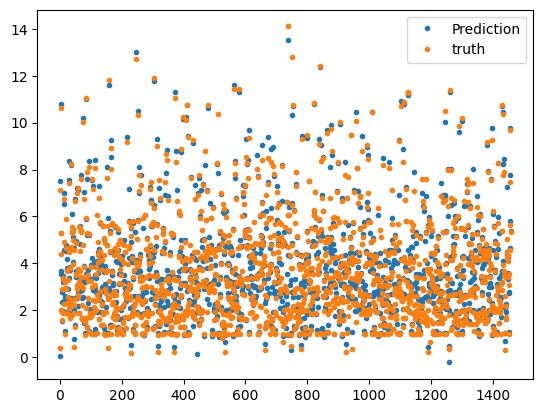

In [17]:
plt.plot(np.array([i for i in range(len(y_pred))]), y_pred.reshape(-1), '.', label="Prediction")
plt.plot(np.array([i for i in range(len(y_pred))]), y_test.values.reshape(-1), '.', label="truth")
plt.legend()
plt.show()